In [1]:
import geopandas as gpd
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, auc, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

import shap 
import warnings
%matplotlib inline

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42

In [3]:
dados = gpd.read_file('data/generate/WGS84_hex_agg_sp_filtred.gpkg')

In [4]:
variables = ['esp_1', 'area_count', "area_mean", "DCL_mean"]
categorical_variables = ['intersects_railway',	'intersects_highway', 'intersects_power', 'intersects_aeroway',	'intersects_natural', 'intersects_waterway']

In [5]:
X = dados.copy()[variables + categorical_variables]


# Convert specified columns to integer type using .loc
X.loc[:, categorical_variables] = \
    X.loc[:, categorical_variables].astype(int)
y = dados[['is_fcu']].astype(int).values

In [6]:
X.head()

,esp_1,area_count,area_mean,DCL_mean,intersects_railway,intersects_highway,intersects_power,intersects_aeroway,intersects_natural,intersects_waterway
0,114.0,63.0,147.878013,6.750791,0,0,0,0,0,0
1,157.0,103.0,80.865535,10.788276,0,0,0,0,0,0
2,70.0,26.0,90.313326,7.683747,0,0,0,0,0,0
3,471.0,174.0,60.442236,6.340379,0,0,0,0,0,0
4,20.0,47.0,180.344743,4.947622,0,0,0,0,1,0


In [7]:
# #train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)


In [8]:
def apply_standard_scaler(scaler, df, columns_to_scale):
    # Copy the dataframe to avoid modifying the original
    df_scaled = df.copy()
    
    # Apply StandardScaler only to the specified columns
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    return df_scaled


In [9]:
X_train.head()

,esp_1,area_count,area_mean,DCL_mean,intersects_railway,intersects_highway,intersects_power,intersects_aeroway,intersects_natural,intersects_waterway
45753,14.0,28.0,136.261782,17.682005,0,1,0,0,0,1
46183,135.0,92.0,89.270754,0.000000,0,0,0,0,0,0
28619,114.0,90.0,62.985117,28.600999,0,0,0,0,0,0
36864,55.0,98.0,85.341659,12.675324,0,0,0,0,0,0
53789,28.0,50.0,88.593745,3.531220,0,0,0,0,0,1


In [10]:
#standScaler = StandardScaler()


#X_train_standScaler = apply_standard_scaler(standScaler, X_train, variables)
#X_test_standScaler = apply_standard_scaler(standScaler, X_test, variables)

X_train_standScaler = X_train

X_test_standScaler = X_test

#X_train_standScaler = pd.DataFrame(standScaler.fit_transform(X_train), columns=X.columns)

#X_test_standScaler = pd.DataFrame(standScaler.fit_transform(X_test), columns=X.columns)


In [11]:
print(f"Size before balancing \nTraining:{X_train_standScaler.shape}, {y_train.shape}\nTeste: {X_test_standScaler.shape}, {y_test.shape}")

Size before balancing 
Training:(43884, 10), (43884, 1)
Teste: (10971, 10), (10971, 1)


In [12]:
from imblearn.over_sampling import SMOTENC

In [13]:
oversample = SMOTENC(random_state=RANDOM_STATE, sampling_strategy=0.2, categorical_features=categorical_variables)
X_train_b, y_train_b = oversample.fit_resample(X_train_standScaler, y_train)


In [14]:
print(f"Size after balancing \nTraining:{X_train_b.shape}, {y_train_b.shape}\nTeste: {X_test.shape}, {y_test.shape}")

Size after balancing 
Training:(49214, 10), (49214,)
Teste: (10971, 10), (10971, 1)


[Text(0.5, 1.0, 'Porcentagem das Classes para teste')]

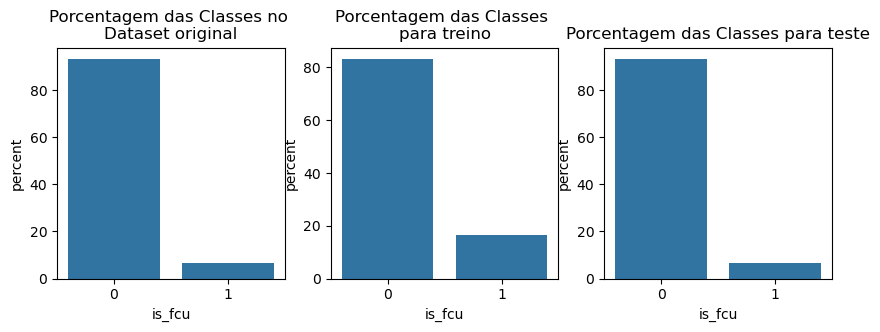

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()

sns.countplot(pd.DataFrame(y, columns=["is_fcu"]), x="is_fcu", stat="percent", ax=axes[0]).set(title="Porcentagem das Classes no \nDataset original")
sns.countplot(pd.DataFrame(y_train_b, columns=["is_fcu"]), x="is_fcu", stat="percent", ax=axes[1]).set(title="Porcentagem das Classes \npara treino")
sns.countplot(pd.DataFrame(y_test, columns=["is_fcu"]), x="is_fcu", stat="percent", ax=axes[2]).set(title="Porcentagem das Classes para teste")


# Modelagem

## Melhor modelo

In [16]:
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME',random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    #'CatBoostClassifier': CatBoostClassifier(random_state=RANDOM_STATE)
}

In [17]:
results_cv = {}


for name, model in models.items():
    scores = cross_validate(
        model,
        X_train_b,
        y_train_b,
        scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'),
        cv=10,
        return_estimator=True,
        n_jobs=-1)
    results_cv[name] = scores

In [18]:
resultado_simplificado = { }
resultado_simplificado_dp = {}
for key, value in results_cv.items():
  resultado_simplificado[key] =  {
      'accuracy': value['test_accuracy'].mean(),
      'precision': value['test_precision'].mean(),
      'recall' : value['test_recall'].mean(),
      'roc_auc' : value['test_roc_auc'].mean(),
      'f1' : value['test_f1'].mean(),
  }

  resultado_simplificado_dp[key] =  {
      'accuracy': value['test_accuracy'].std(),
      'precision': value['test_precision'].std(),
      'recall' : value['test_recall'].std(),
      'roc_auc' : value['test_roc_auc'].std(),
      'f1' : value['test_f1'].std(),
  }

  print(f"{key} CV accuracy: {resultado_simplificado[key]['accuracy']} ± {resultado_simplificado_dp[key]['accuracy']}")
  print(f"{key} CV precision: {resultado_simplificado[key]['precision']} ± {resultado_simplificado_dp[key]['precision']}")
  print(f"{key} CV recall: {resultado_simplificado[key]['recall']} ± {resultado_simplificado_dp[key]['recall']}")
  print(f"{key} CV roc_auc: {resultado_simplificado[key]['roc_auc']} ± {resultado_simplificado_dp[key]['roc_auc']}")
  print(f"{key} CV f1: {resultado_simplificado[key]['f1']} ± {resultado_simplificado_dp[key]['f1']}")




DecisionTree CV accuracy: 0.877352556413272 ± 0.007860684524259262
DecisionTree CV precision: 0.6234290623438603 ± 0.019180329095639128
DecisionTree CV recall: 0.6649674697721399 ± 0.046815120283447496
DecisionTree CV roc_auc: 0.7923979814618358 ± 0.023080711365542524
DecisionTree CV f1: 0.6431013571088889 ± 0.0304825171522656
RandomForest CV accuracy: 0.9202267463468514 ± 0.008561218217278257
RandomForest CV precision: 0.8023822697643175 ± 0.01678118529243325
RandomForest CV recall: 0.6911835655506372 ± 0.052718185267615195
RandomForest CV roc_auc: 0.9543352852744416 ± 0.010845439196596026
RandomForest CV f1: 0.741796120977675 ± 0.03520160901192326
GradientBoosting CV accuracy: 0.8799937055043024 ± 0.004177051105510386
GradientBoosting CV precision: 0.7103129292989447 ± 0.02157156488216714
GradientBoosting CV recall: 0.47366804313597344 ± 0.02178555295812485
GradientBoosting CV roc_auc: 0.9055524401989725 ± 0.006337425113952697
GradientBoosting CV f1: 0.567951560075746 ± 0.01761247396

In [19]:
mean_results = pd.DataFrame(resultado_simplificado)
std_results = pd.DataFrame(resultado_simplificado_dp)

In [20]:
mean_results.head()

,DecisionTree,RandomForest,GradientBoosting,AdaBoost,XGBoost,KNN,HistGradientBoostingClassifier
accuracy,0.877353,0.920227,0.879994,0.864287,0.894258,0.893628,0.890255
precision,0.623429,0.802382,0.710313,0.656930,0.726188,0.682144,0.723619
recall,0.664967,0.691184,0.473668,0.389904,0.586327,0.676793,0.553041
roc_auc,0.792398,0.954335,0.905552,0.871579,0.930924,0.922205,0.926095
f1,0.643101,0.741796,0.567952,0.488982,0.648447,0.679171,0.626467


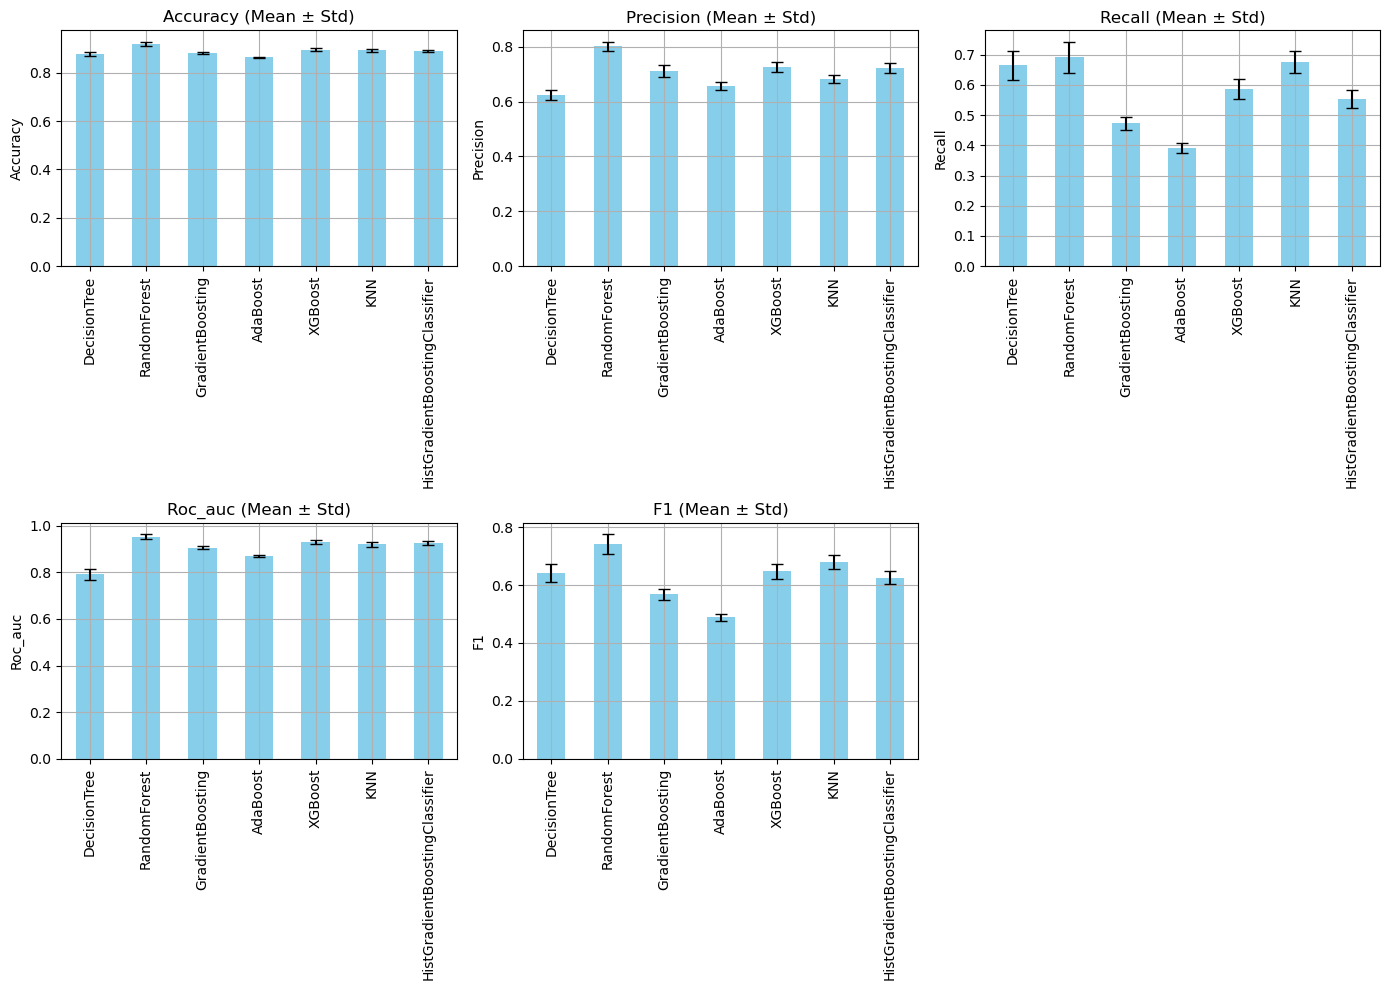

In [21]:
# Plotando a média e o desvio padrão lado a lado
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()
metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

for i, metric in enumerate(metrics):
    ax = axes[i]
    mean_values = mean_results.loc[metric]
    std_values = std_results.loc[metric]
    
    mean_values.plot(kind='bar', yerr=std_values, ax=ax, capsize=4, color='skyblue')
    ax.set_title(f'{metric.capitalize()} (Mean ± Std)')
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)

# Hide any unused axes
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [22]:
from scipy.stats import ttest_rel

# Define the models to compare (DecisionTree and XGBoost)
models_to_test = ['DecisionTree', 'XGBoost', 'RandomForest']

# Create an empty list to store the test results
results_list = []

# Function to perform the paired t-test and append results to the list
def perform_t_test(reference_model, target_model, metric='test_roc_auc'):
    ref_scores = results_cv[reference_model][metric]
    target_scores = results_cv[target_model][metric]
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(ref_scores, target_scores)
    
    # Determine whether to reject the null hypothesis
    confidence_level = 0.95
    significant = 'Yes' if p_value < (1 - confidence_level) else 'No'
    
    # Append the result to the list
    results_list.append({
        'Reference Model': reference_model,
        'Compared Model': target_model,
        'Metric': metric,
        'T-statistic': t_stat,
        'P-value': p_value,
        'Significant Difference (95%)': significant
    })

# Loop through all models and compare with DecisionTree and XGBoost
for ref_model in models_to_test:
    for model_name in results_cv.keys():
        if model_name != ref_model:  # Avoid comparing the model with itself
            perform_t_test(ref_model, model_name, 'test_recall')

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the DataFrame

results_df


,Reference Model,Compared Model,Metric,T-statistic,P-value,Significant Difference (95%)
0,DecisionTree,RandomForest,test_recall,-5.110040,6.364687e-04,Yes
1,DecisionTree,GradientBoosting,test_recall,15.012052,1.120260e-07,Yes
2,DecisionTree,AdaBoost,test_recall,18.124763,2.159688e-08,Yes
3,DecisionTree,XGBoost,test_recall,12.768886,4.528950e-07,Yes
4,DecisionTree,KNN,test_recall,-1.678221,1.276135e-01,No
5,DecisionTree,HistGradientBoostingClassifier,test_recall,11.705699,9.510900e-07,Yes
6,XGBoost,DecisionTree,test_recall,-12.768886,4.528950e-07,Yes
7,XGBoost,RandomForest,test_recall,-12.750722,4.584549e-07,Yes
8,XGBoost,GradientBoosting,test_recall,13.958126,2.104597e-07,Yes
9,XGBoost,AdaBoost,test_recall,17.400089,3.089252e-08,Yes


# Melhor Modelo

In [53]:
def model_eval(model,X_train,y_train,X_test,y_test,classes=None,
                           normalize='true',cmap='Blues',label=''):

    """Example function with PEP 484 type annotations.

        Args:
            model: The Model Classifier.
            X_train: X_train being used to fit model (could be scaled or not).
            y_train: y_train being used to fit model and to get train accuracy.
            X_test: X_test to get test predictions.
            y_test: y_test used to get test accuracy

        Returns:
            Model Accuracy. Confusion Matrix, ROC Curve, and best params for GridSearch

    """
    
    
    #FITTING MODEL WITH TRAIN DATA
    #model.fit(X_train,y_train)   
      
    #GETTING TRAIN PREDICTIONS
    y_hat_train = model.predict(X_train)
    
    #GETING TEST PREDICTIONS
    y_hat_test = model.predict(X_test)
    
    dashes = '---'*20
    
    if isinstance(model,GridSearchCV):
        grid_header = "GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: "
        print(dashes,grid_header,dashes,sep='\n')
        best_parameters = model.best_params_
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))
    
    #GETTING ACCURACY SCORE FOR TRAIN AND TEST
    
    if len(label)>0:
        accuracy_header = f'{label} ACCURACY'
    else:
        accuracy_header = 'MODEL ACCURACY'
    print(dashes,accuracy_header,dashes,sep='\n')
    training_accuracy = accuracy_score(y_train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
    print(f'TRAINING ACCURACY: {round(training_accuracy*100,2)}%')
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
    
     
    if len(label)>0:
        accuracy_header = f'{label} RECALL'
    else:
        accuracy_header = 'MODEL RECALL'

    print(dashes,accuracy_header,dashes,sep='\n')
    training_recall = recall_score(y_train, y_hat_train)
    testing_recall = recall_score(y_test, y_hat_test)
    
    print(f'TRAINING RECALL: {round(training_recall*100,2)}%')
    print(f'TESTING RECALL: {round(testing_recall*100,2)}%')

    #CLASSIFICATION REPORT AND SCORES
    test_header = "CLASSIFICATION REPORT"
    
    #ADDING LABEL IF GIVEN
    if len(label)>0:
        test_header += f" USING {label}"
    
    # PRINT CLASSIFICATION REPORT
    
    print(dashes,test_header,dashes,sep='\n')

    print(classification_report(y_test,y_hat_test,
                                    target_names=classes))

    print(dashes+"\n\n")
    
    

    # MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    # PLOTTING CONFUSION MATRIX 

    
    #cm = confusion_matrix(, labels=model.classes_)
    ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test, labels=model.classes_, ax=axes[0], cmap=cmap)
    axes[0].set(title='Confusion Matrix')
    
    #PLOTTING ROC CURVE
    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay.from_predictions(y_test, y_hat_test, ax=axes[1])
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    #fig.tight_layout()
    
    
    plt.show()


### Random Forest

In [24]:
param_grid_random_forest = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [10, 50],
    'class_weight': [None, 'balanced']
}

param_grid_random_forest = {
    #'class_weight': [None, 'balanced'],
   
}

In [54]:
grid_search_RandomForest = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid_random_forest,
    cv=10,
    scoring='recall',
    n_jobs=-1,
    verbose=3
    )
grid_search_RandomForest.fit(X_train_b, y_train_b)

print("Melhores parametros Para  RandomForestClassifier:", grid_search_RandomForest.best_params_)
print("Melhor CV recall para RandomForestClassifier:", grid_search_RandomForest.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .................................., score=0.602 total time=  13.5s
[CV 2/10] END .................................., score=0.630 total time=  13.5s
[CV 4/10] END .................................., score=0.671 total time=  13.5s
[CV 3/10] END .................................., score=0.624 total time=  13.6s
[CV 6/10] END .................................., score=0.755 total time=  13.5s
[CV 10/10] END ................................., score=0.711 total time=  13.4s
[CV 8/10] END .................................., score=0.715 total time=  13.5s
[CV 9/10] END .................................., score=0.717 total time=  13.5s
[CV 5/10] END .................................., score=0.734 total time=  13.6s
[CV 7/10] END .................................., score=0.752 total time=  13.6s
Melhores parametros Para  RandomForestClassifier: {}
Melhor CV recall para RandomForestClassifier: 0.6911835655506372


In [48]:
#model_grid_search_RandomForest = grid_search_RandomForest.best_estimator_

------------------------------------------------------------
GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: 
------------------------------------------------------------
------------------------------------------------------------
RandomForest ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 100.0%
TESTING ACCURACY: 93.12%
------------------------------------------------------------
RandomForest RECALL
------------------------------------------------------------
TRAINING RECALL: 99.99%
TESTING RECALL: 39.38%
------------------------------------------------------------
CLASSIFICATION REPORT USING RandomForest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10232
           1       0.49      0.39      0.44       739

    accuracy                           0.93     10971
   macro avg       0.72      0.68      0.70     10971
weight

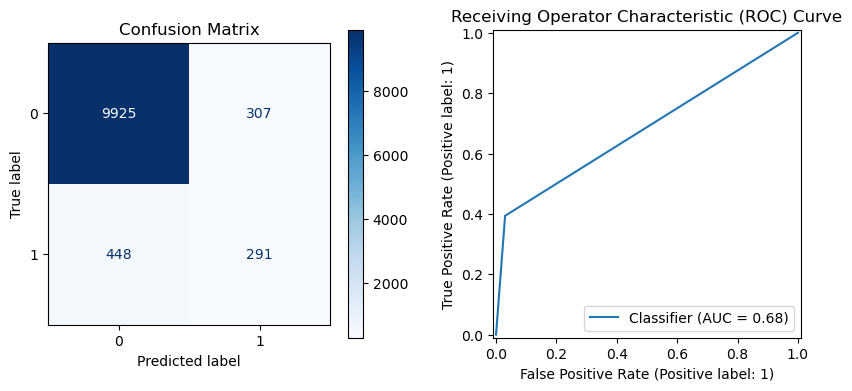

In [55]:
model_eval(grid_search_RandomForest, X_train_b, y_train_b, X_test_standScaler, y_test,label='RandomForest')

#### Model Results

In [29]:
X.head()

,esp_1,area_count,area_mean,DCL_mean,intersects_railway,intersects_highway,intersects_power,intersects_aeroway,intersects_natural,intersects_waterway
0,114.0,63.0,147.878013,6.750791,0,0,0,0,0,0
1,157.0,103.0,80.865535,10.788276,0,0,0,0,0,0
2,70.0,26.0,90.313326,7.683747,0,0,0,0,0,0
3,471.0,174.0,60.442236,6.340379,0,0,0,0,0,0
4,20.0,47.0,180.344743,4.947622,0,0,0,0,1,0


In [56]:
standScalerAll = StandardScaler()
#x_all = apply_standard_scaler(standScalerAll, X, variables)
x_all = X

In [57]:
y_all_hat = grid_search_RandomForest.predict_proba(x_all)
y_all_hat_val = grid_search_RandomForest.predict(x_all)


In [60]:
sao_remo_poli = dados[dados['id_hex'] == '8aa81005aadffff'].index[0]
oscar_freire = dados[dados['id_hex'] == '8aa8100ea147fff'].index[0]

buracana = dados[dados['id_hex'] == '8aa81005aa8ffff'].index[0]

test = dados[dados['id_hex'] == '8aa8103b4a37fff'].index[0]

In [61]:
y_all_hat[buracana]

array([0.11, 0.89])

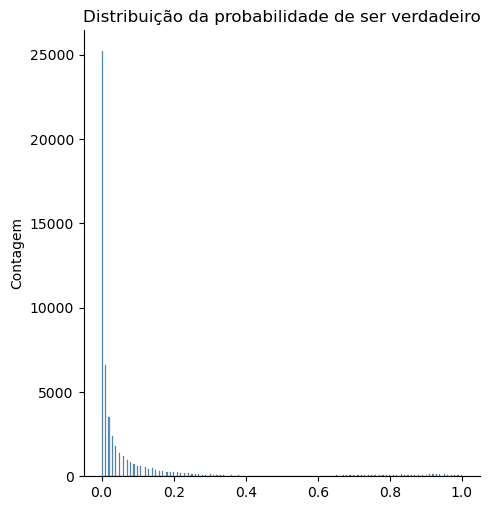

In [34]:
sns.displot(y_all_hat[:, 1]). set(title='Distribuição da probabilidade de ser verdadeiro', ylabel='Contagem')


In [35]:
all_recall = recall_score(y, y_all_hat_val)
    
print(f'All RECALL: {round(all_recall*100,2)}%')

All RECALL: 87.59%


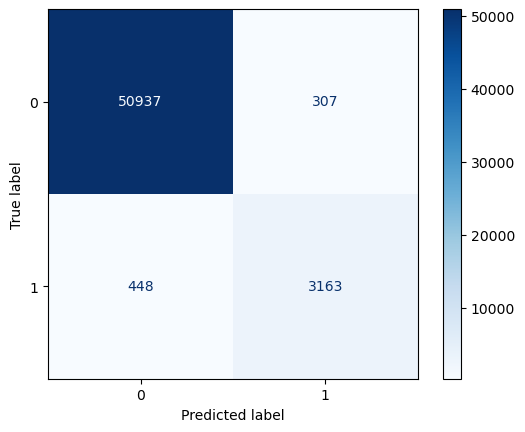

In [36]:

# PLOTTING CONFUSION MATRIX 
   
ConfusionMatrixDisplay.from_predictions(y, y_all_hat_val, labels=grid_search_RandomForest.classes_, cmap='Blues', )

# Shape Random Forest

In [37]:
explainer = shap.TreeExplainer(grid_search_RandomForest, X_train_b)
shap.plots.initjs()

In [38]:
X_train_b.shape

(49214, 10)

In [39]:
explainer.expected_value

array([0.8237, 0.1763])

In [40]:
x_all[:1000].shape

(1000, 10)

In [41]:
shap_values = explainer(X_train_b[:1000])

 99%|===================| 1985/2000 [01:19<00:00]        

In [42]:
shap_values.shape

(1000, 10, 2)

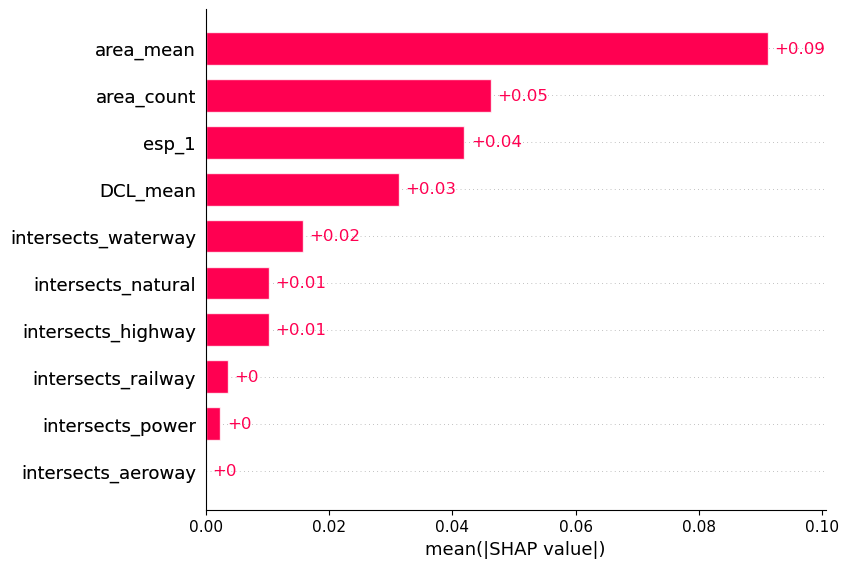

In [43]:
shap.plots.bar(shap_values[:, :, 1], max_display=16)

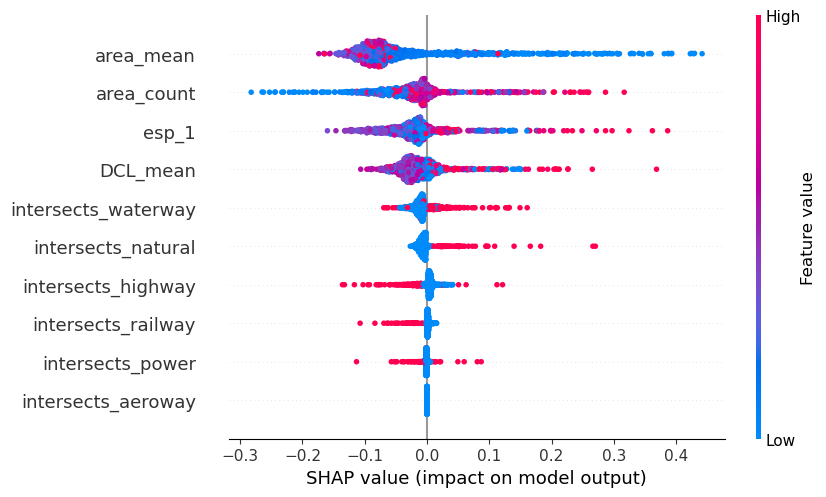

In [44]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=16)


In [45]:
# São Remo poligono 
shap.plots.waterfall(shap_values[sao_remo_poli, :, 1])

IndexError: index 22012 is out of bounds for axis 0 with size 1000

In [121]:
shap.force_plot(explainer.expected_value[1], shap_values[buracana, :, 1].values, feature_names=(x_all.columns))

IndexError: index 52442 is out of bounds for axis 0 with size 1000

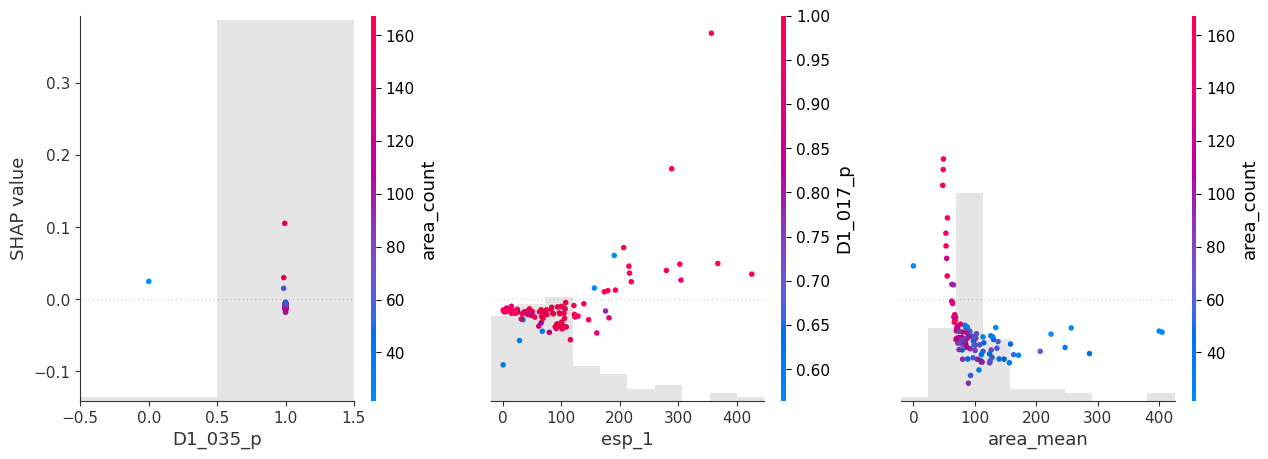

In [49]:

shap.plots.scatter(shap_values[:, ['D1_035_p', 'esp_1', 'area_mean'], 1], color=shap_values[:, :, 1], hist=False)



In [50]:
condition_outlier = y_all_hat_val == 1
qnt_pred_as_true = condition_outlier.sum()

true_pred =  sum(y[y_all_hat_val == 1])

print(qnt_pred_as_true, true_pred)

3176 [2895]


In [51]:
falso_positivo_condition = ((y_all_hat_val == 1) & (y == 0))
falso_negativo_condition = (y_all_hat_val  == 0) & (y == 1)
true_condition = (y_all_hat_val == 1) & (y == 1)
false_condition = (y_all_hat_val == 0) & (y == 0)


### Analise dos erros tipo i e ii


In [ ]:
# Analise falso positivo
T = x_all[falso_positivo_condition]
sh_fp = explainer(T)


  0%|                   | 40758/313483904 [26:51<206485:48]       

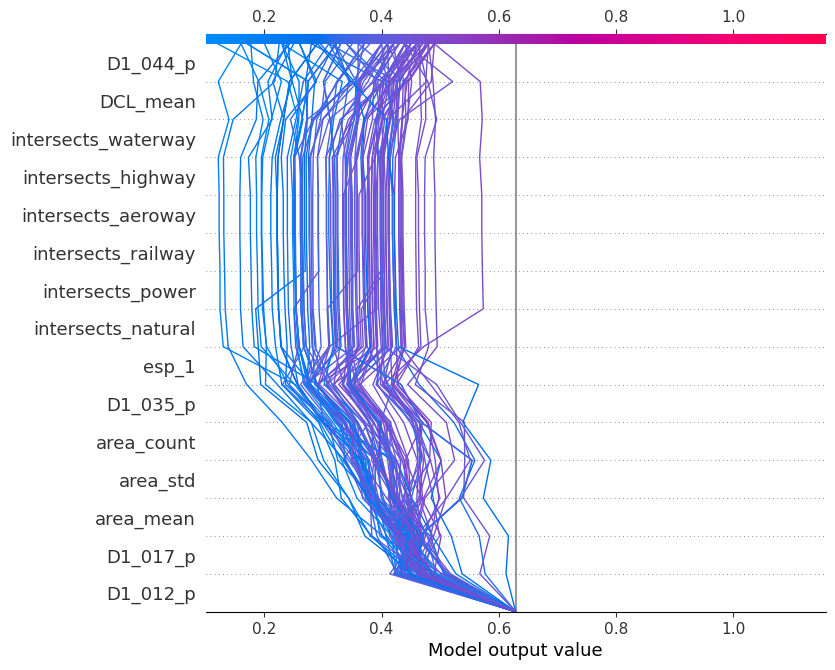

In [166]:
with warnings.catch_warnings():
    r = shap.decision_plot(explainer.expected_value[0], sh_fp[:100, :, 0].values, T[:100], feature_order="hclust", return_objects=True, ignore_warnings=True)

In [167]:
# Analise falso negativo
T = x_all[falso_negativo_condition]
sh_fn = explainer(T)


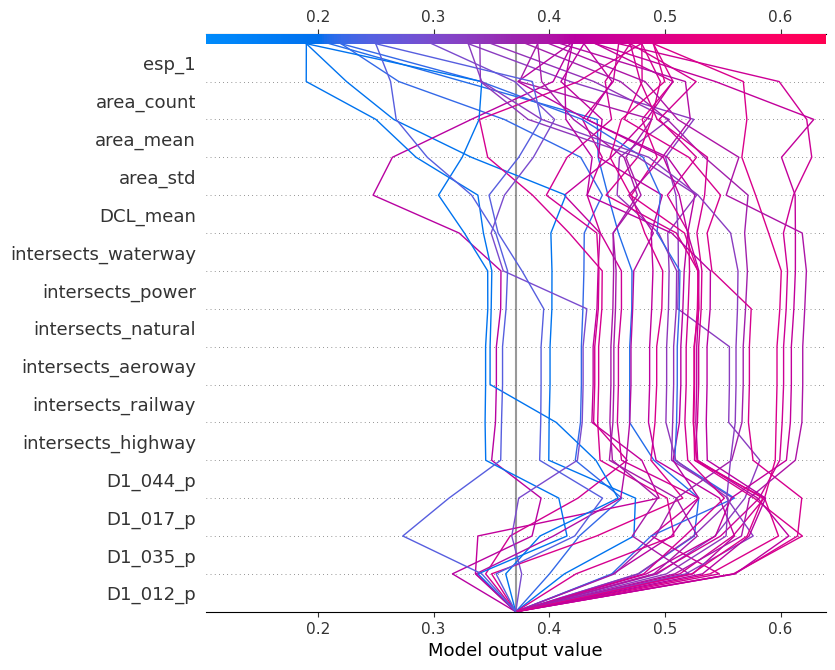

In [168]:
r = shap.decision_plot(explainer.expected_value[1], sh_fn[:, :, 1].values, T, feature_order="hclust", return_objects=True)

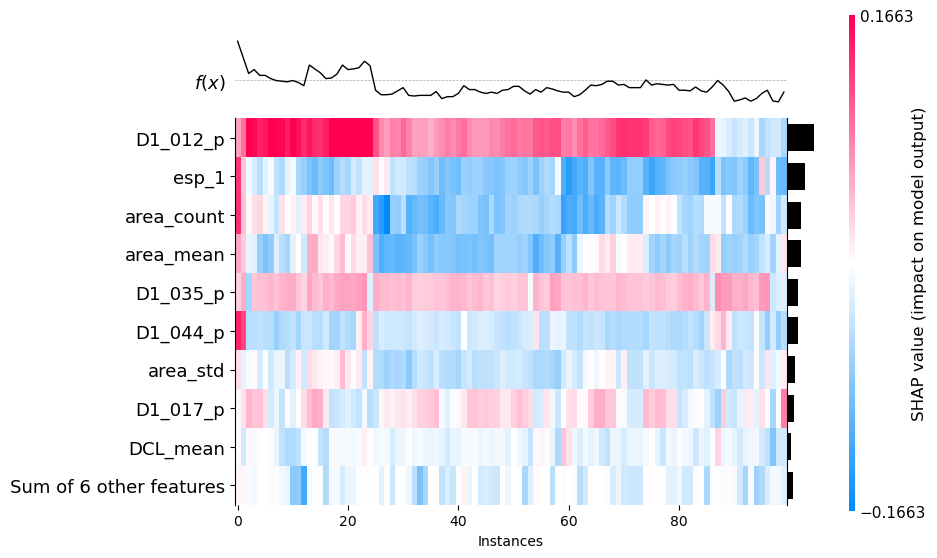

<Axes: xlabel='Instances'>

In [169]:
shap.plots.heatmap(shap_values[:100, : , 1])

In [238]:
import pickle

# Assuming `shap_values` is the result from `explainer(x_all)`
with open("data/model/shap_values_model_sem_iptu.pkl", "wb") as file:
    pickle.dump(shap_values, file)

## Saving probability and classification

In [245]:
dados['is_fav_prob_model1'] = y_all_hat[:, 1]

dados.loc[falso_positivo_condition, 'model1_result'] = 'FP'
dados.loc[falso_negativo_condition, 'model1_result'] = 'FN'
dados.loc[true_condition, 'model1_result'] = 'P'
dados.loc[false_condition, 'model1_result'] = 'N'


In [249]:
dados.to_file("data/generate/WGS84_hex_sp_model_fcu_sempitu.gpkg", driver="GPKG")